In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Загружаем данные

In [33]:
df_matches = pd.read_csv("data/match.csv")
df_players = pd.read_csv("data/players.csv")

heroes = pd.read_csv("data/hero_names.csv")
heroes= heroes.drop("name",axis=1) 
items = pd.read_csv("data/item_ids.csv")

Смотрим нулевые значения таблицы матчей, их нет

In [34]:
df_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   match_id                 50000 non-null  int64
 1   start_time               50000 non-null  int64
 2   duration                 50000 non-null  int64
 3   tower_status_radiant     50000 non-null  int64
 4   tower_status_dire        50000 non-null  int64
 5   barracks_status_dire     50000 non-null  int64
 6   barracks_status_radiant  50000 non-null  int64
 7   first_blood_time         50000 non-null  int64
 8   game_mode                50000 non-null  int64
 9   radiant_win              50000 non-null  bool 
 10  negative_votes           50000 non-null  int64
 11  positive_votes           50000 non-null  int64
 12  cluster                  50000 non-null  int64
dtypes: bool(1), int64(12)
memory usage: 4.6 MB


Исключаем избыточные данные

In [35]:
matches = df_matches.copy()
matches.drop(["start_time", "game_mode", "negative_votes", "positive_votes", "cluster"], axis = 1, inplace = True)

players = df_players.copy()

Смотрим первые 5 строк таблицы матчей

In [36]:
matches.head()

,match_id,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,radiant_win
0,0,2375,1982,4,3,63,1,True
1,1,2582,0,1846,63,0,221,False
2,2,2716,256,1972,63,48,190,False
3,3,3085,4,1924,51,3,40,False
4,4,1887,2047,0,0,63,58,True


Смотрим колонки таблицы игроков, в них много столбцов начинающихся на 'unit', которые хранят избыточную информацию. Удаляем их

In [37]:
players.columns

Index(['match_id', 'account_id', 'hero_id', 'player_slot', 'gold',
       'gold_spent', 'gold_per_min', 'xp_per_min', 'kills', 'deaths',
       'assists', 'denies', 'last_hits', 'stuns', 'hero_damage',
       'hero_healing', 'tower_damage', 'item_0', 'item_1', 'item_2', 'item_3',
       'item_4', 'item_5', 'level', 'leaver_status', 'xp_hero', 'xp_creep',
       'xp_roshan', 'xp_other', 'gold_other', 'gold_death', 'gold_buyback',
       'gold_abandon', 'gold_sell', 'gold_destroying_structure',
       'gold_killing_heros', 'gold_killing_creeps', 'gold_killing_roshan',
       'gold_killing_couriers', 'unit_order_none',
       'unit_order_move_to_position', 'unit_order_move_to_target',
       'unit_order_attack_move', 'unit_order_attack_target',
       'unit_order_cast_position', 'unit_order_cast_target',
       'unit_order_cast_target_tree', 'unit_order_cast_no_target',
       'unit_order_cast_toggle', 'unit_order_hold_position',
       'unit_order_train_ability', 'unit_order_drop_item',


In [38]:
col_to_remove = []
for col in players.columns:
    if 'unit' in col:
        col_to_remove.append(col)
        
players = players.drop(col_to_remove,axis=1)

Смотрим наличие нулевых значений в таблице игроков, в данном контексте пустые значения можно заменить нулем

In [39]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 39 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   match_id                   500000 non-null  int64  
 1   account_id                 500000 non-null  int64  
 2   hero_id                    500000 non-null  int64  
 3   player_slot                500000 non-null  int64  
 4   gold                       500000 non-null  int64  
 5   gold_spent                 500000 non-null  int64  
 6   gold_per_min               500000 non-null  int64  
 7   xp_per_min                 500000 non-null  int64  
 8   kills                      500000 non-null  int64  
 9   deaths                     500000 non-null  int64  
 10  assists                    500000 non-null  int64  
 11  denies                     500000 non-null  int64  
 12  last_hits                  500000 non-null  int64  
 13  stuns                      34

In [40]:
players.fillna(0,inplace=True)

Заменям id предметов их названиями

In [41]:
items_dict = dict(zip(items['item_id'], items['item_name']))

for col in ['item_0', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5']:
    players[col] = players[col].map(items_dict)

In [42]:
players2 = players[['match_id','account_id','hero_id', 'item_0', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5']]

Добавляем столбец, описывающий принадлежит ли игрок команде radiant. Данные в датасете отсортированы по матчам, и первые пять строк матча принадлежат команде radiant, а остальные 5 команде dire

In [43]:
def check_player_radiant(row):
    if (row.name%10) < 5:
        return True
    return False

players2 = players2.copy()
players2["is_radiant"] = players2.apply(lambda row: check_player_radiant(row), axis=1)

Замечаем, что в таблице с именами героев пропущен id = 24. В таблице игроков также он пропущен, но значения идут с 0, а не с 1 как в таблице с героями. Исправляем эту ошибку увеличив hero_id в таблице игроков на 1

In [44]:
print(sorted(heroes['hero_id'].unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113]


In [45]:
print(sorted(df_players['hero_id'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112]


In [46]:
players2['hero_id'] = players2['hero_id'] + 1

Заменяем id героя на его имя

In [47]:
players2 = players2.merge(heroes, on="hero_id")
players2.rename(columns={'localized_name': 'hero_name'}, inplace=True)
players2 = players2.sort_values(by="match_id", ascending=True).reset_index()

In [48]:
matches = matches.merge(players2, on="match_id")

Выбираем колонки для дальнейшего анализа и создаем новый столбик, описывающий победу или поражение. Для создания этого столбца используем исключающее ИЛИ, которое возвращает True если оба значения столбцов одинаковы.

In [49]:
win_rate = matches[["match_id","account_id","hero_id","hero_name","is_radiant","radiant_win", 'item_0', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5']].copy()
win_rate["is_win"] = win_rate.apply(lambda row: not (row["is_radiant"] ^ row["radiant_win"])  ,axis=1)

In [50]:
win_rate["is_played"] = 1

Считаем долю побед для персонажей и предметов

In [51]:
players_wr=win_rate.groupby(by=["hero_name"])[["is_win","is_played"]].sum().reset_index()
players_wr['win_rate'] = players_wr['is_win']/players_wr['is_played']*100

In [52]:
items_wr = win_rate.melt(id_vars='is_win', value_vars=['item_0', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5'])
items_wr.rename(columns={'value': 'item'}, inplace=True)

items_wr=items_wr.groupby('item').agg({'is_win': 'sum', 'item': 'count'}).rename(columns={'item': 'is_played'})
items_wr['win_rate'] = items_wr['is_win']/items_wr['is_played']*100

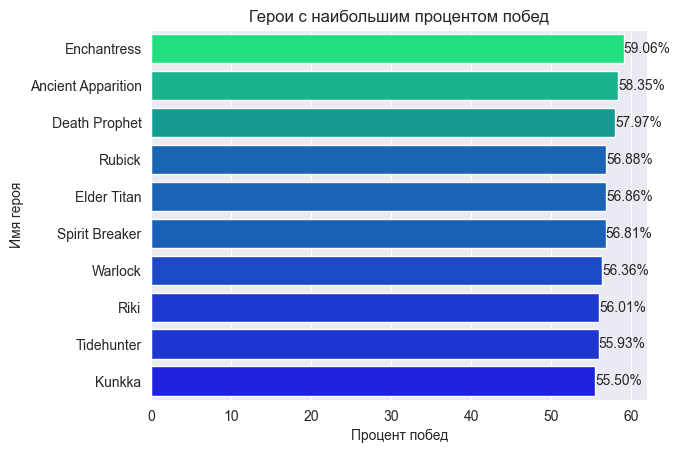

In [53]:
plt.title("Герои с наибольшим процентом побед")
ax = sns.barplot(x='win_rate', y='hero_name', data=players_wr.sort_values(by='win_rate',ascending=False).head(10), orient='h', palette='winter', hue='win_rate', legend=False)
ax.set_xlabel('Процент побед')
ax.set_ylabel('Имя героя')
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f%%')
plt.show()

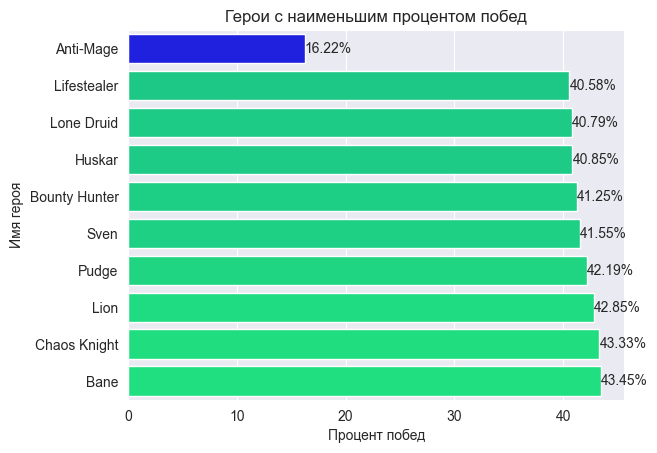

In [54]:
plt.title("Герои с наименьшим процентом побед")
ax = sns.barplot(x='win_rate', y='hero_name', data=players_wr.sort_values(by='win_rate',ascending=True).head(10), orient='h', palette='winter', hue='win_rate', legend=False)
ax.set_xlabel('Процент побед')
ax.set_ylabel('Имя героя')
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f%%')
plt.show()

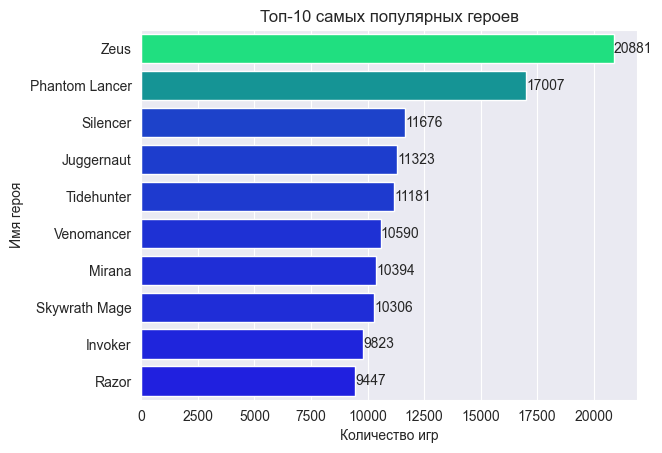

In [55]:
plt.title("Топ-10 самых популярных героев")
ax = sns.barplot(x='is_played', y='hero_name', data=players_wr.sort_values(by='is_played', ascending=False).head(10),
                 orient='h', palette='winter', hue='is_played', legend=False)
ax.set_xlabel('Количество игр')
ax.set_ylabel('Имя героя')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

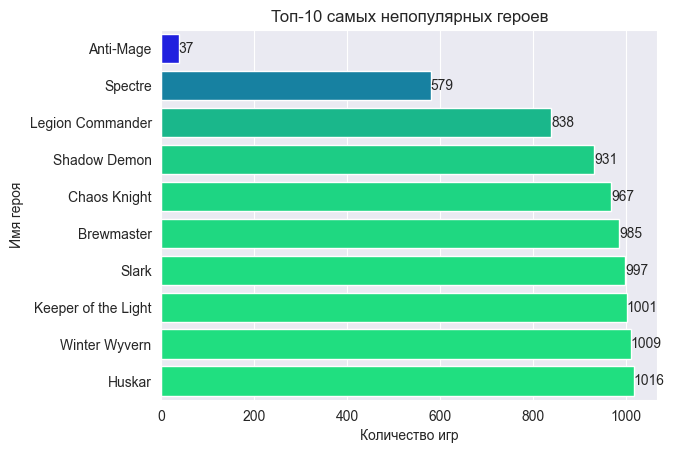

In [56]:
plt.title("Топ-10 самых непопулярных героев")
ax = sns.barplot(x='is_played', y='hero_name', data=players_wr.sort_values(by='is_played', ascending=True).head(10),
                 orient='h', palette='winter', hue='is_played', legend=False)
ax.set_xlabel('Количество игр')
ax.set_ylabel('Имя героя')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

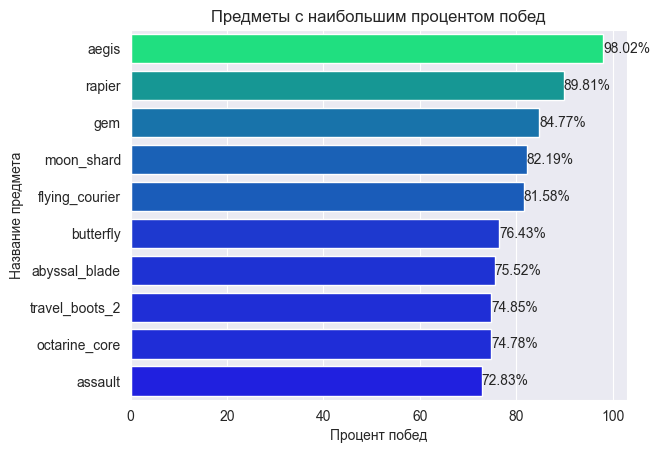

In [57]:
plt.title("Предметы с наибольшим процентом побед")
ax = sns.barplot(x='win_rate', y='item', data=items_wr.sort_values(by='win_rate',ascending=False).head(10), orient='h', palette='winter', hue='win_rate', legend=False)
ax.set_xlabel('Процент побед')
ax.set_ylabel('Название предмета')
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f%%')
plt.show()

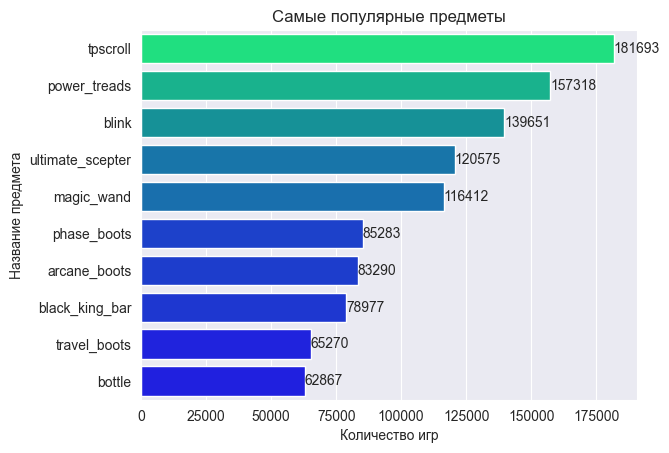

In [58]:
plt.title("Самые популярные предметы")
ax = sns.barplot(x='is_played', y='item', data=items_wr.sort_values(by='is_played', ascending=False).head(10),
                 orient='h', palette='winter', hue='is_played', legend=False)
ax.set_xlabel('Количество игр')
ax.set_ylabel('Название предмета')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

Смотрим распределение целевой переменной. Датасет почти сбалансирован

In [59]:
print(matches['radiant_win'].value_counts())

radiant_win
True     258082
False    239375
Name: count, dtype: int64


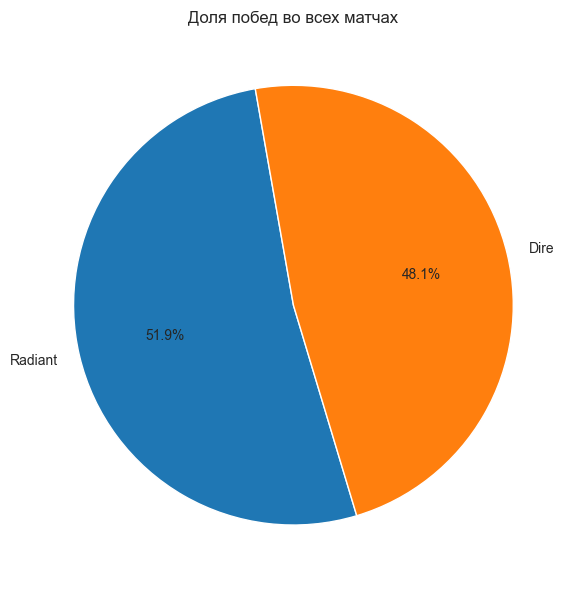

In [60]:
radiant_wins = matches[matches['is_radiant'] & matches['radiant_win']].shape[0]
dire_wins = matches[(matches['is_radiant'] == False) & (matches['radiant_win'] == False)].shape[0]

plt.figure(figsize=(6, 6))
plt.title('Доля побед во всех матчах')
plt.pie([radiant_wins, dire_wins], labels=['Radiant', 'Dire'], startangle=100, autopct='%.1f%%')
plt.tight_layout()
plt.show()